In [2]:
# Cellule 1: setup stable (disable dynamo/inductor BEFORE importing torch)
import os
os.environ["TORCH_DISABLE_DYNAMO"] = "1"
os.environ["TORCHINDUCTOR_DISABLE"] = "1"

import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as TF

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device:", device)


torch: 2.8.0+cu126
cuda available: False
device: cpu


In [3]:
# Cellule 2: locate dataset in /kaggle/input and set DS_ROOT
from pathlib import Path

DATA_ROOT = Path("/kaggle/input")

print("Folders in /kaggle/input:")
for p in DATA_ROOT.iterdir():
    if p.is_dir():
        print(" -", p.name)

DS_ROOT = DATA_ROOT / "covidqu"
print("\nDS_ROOT =", DS_ROOT)
print("Exists:", DS_ROOT.exists())

# Quick preview (2 levels deep)
print("\nTop-level contents of DS_ROOT:")
for p in DS_ROOT.iterdir():
    print(" -", p.name)

# Show the path we will use later
BASE_DIR = DS_ROOT / "Infection Segmentation Data" / "Infection Segmentation Data"
print("\nBASE_DIR =", BASE_DIR)
print("Exists:", BASE_DIR.exists())


Folders in /kaggle/input:
 - covidqu

DS_ROOT = /kaggle/input/covidqu
Exists: True

Top-level contents of DS_ROOT:
 - COVID-QU-Ex dataset.txt
 - Infection Segmentation Data
 - Lung Segmentation Data

BASE_DIR = /kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data
Exists: True


In [4]:
# Cellule 3: define Train / Val / Test paths (infection segmentation)

from pathlib import Path

BASE_DIR = Path("/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data")

TRAIN_DIR = BASE_DIR / "Train"
VAL_DIR   = BASE_DIR / "Val"
TEST_DIR  = BASE_DIR / "Test"

print("TRAIN_DIR exists:", TRAIN_DIR.exists())
print("VAL_DIR exists  :", VAL_DIR.exists())
print("TEST_DIR exists :", TEST_DIR.exists())

TRAIN_DIR, VAL_DIR, TEST_DIR


TRAIN_DIR exists: True
VAL_DIR exists  : True
TEST_DIR exists : True


(PosixPath('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train'),
 PosixPath('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val'),
 PosixPath('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test'))

In [5]:
# Cellule 4: inspect Train directory structure

def inspect_dir(d):
    print(f"\nContents of: {d}")
    for p in sorted(d.iterdir()):
        if p.is_dir():
            print(" -", p.name, "(dir)")
        else:
            print(" -", p.name, "(file)")

inspect_dir(TRAIN_DIR)



Contents of: /kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train
 - COVID-19 (dir)
 - Non-COVID (dir)
 - Normal (dir)


In [6]:
# Cellule 5: inspect Train/COVID-19 structure

COVID_TRAIN = TRAIN_DIR / "COVID-19"

def inspect_dir(d):
    print(f"\nContents of: {d}")
    for p in sorted(d.iterdir()):
        if p.is_dir():
            print(" -", p.name, "(dir)")
        else:
            print(" -", p.name, "(file)")

inspect_dir(COVID_TRAIN)



Contents of: /kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19
 - images (dir)
 - infection masks (dir)
 - lung masks (dir)


In [7]:
# Cellule 6: index images and infection masks (Train / Val / Test)

IMG_EXTS = {".png", ".jpg", ".jpeg"}

def index_by_stem(folder):
    return {
        p.stem: p
        for p in folder.iterdir()
        if p.is_file() and p.suffix.lower() in IMG_EXTS
    }

def build_split_index(split_dir):
    covid_dir = split_dir / "COVID-19"
    img_dir = covid_dir / "images"
    mask_dir = covid_dir / "infection masks"

    imgs = index_by_stem(img_dir)
    masks = index_by_stem(mask_dir)

    common_ids = sorted(set(imgs.keys()) & set(masks.keys()))
    missing_imgs = set(masks.keys()) - set(imgs.keys())
    missing_masks = set(imgs.keys()) - set(masks.keys())

    return imgs, masks, common_ids, missing_imgs, missing_masks

train_imgs, train_masks, train_ids, miss_i_tr, miss_m_tr = build_split_index(TRAIN_DIR)
val_imgs,   val_masks,   val_ids,   miss_i_va, miss_m_va = build_split_index(VAL_DIR)
test_imgs,  test_masks,  test_ids,  miss_i_te, miss_m_te = build_split_index(TEST_DIR)

print("Train pairs:", len(train_ids))
print("Val pairs  :", len(val_ids))
print("Test pairs :", len(test_ids))

print("\nMissing in Train - images:", len(miss_i_tr), "masks:", len(miss_m_tr))
print("Missing in Val   - images:", len(miss_i_va), "masks:", len(miss_m_va))
print("Missing in Test  - images:", len(miss_i_te), "masks:", len(miss_m_te))


Train pairs: 1864
Val pairs  : 466
Test pairs : 583

Missing in Train - images: 0 masks: 0
Missing in Val   - images: 0 masks: 0
Missing in Test  - images: 0 masks: 0


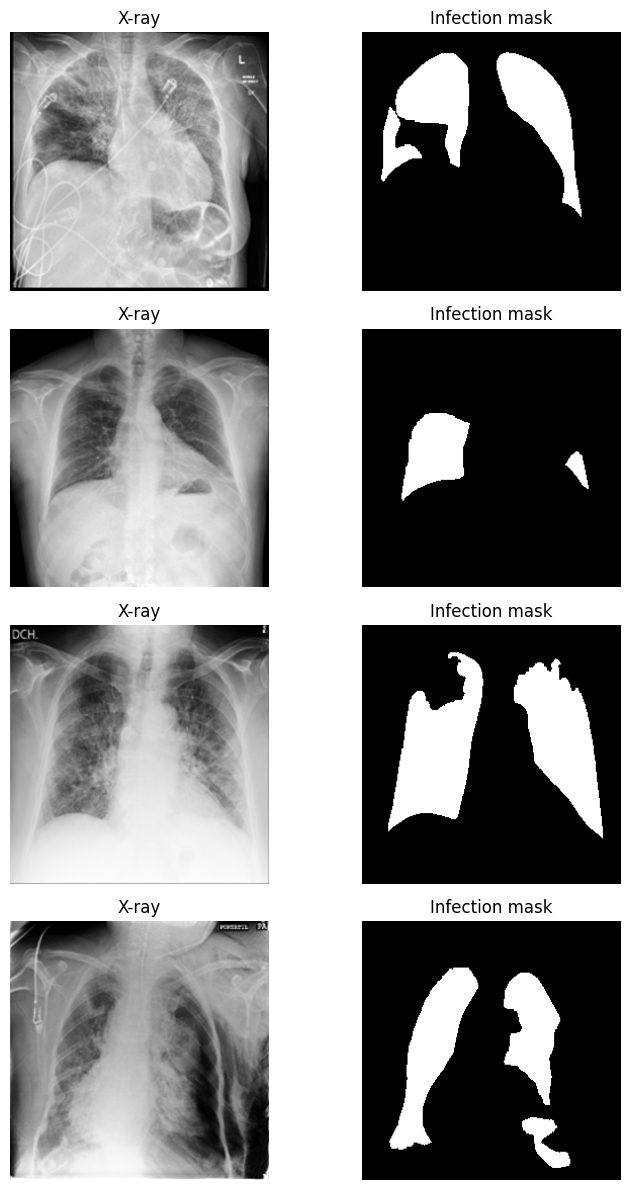

In [8]:
# Cellule 7: visualize image / infection mask pairs

import matplotlib.pyplot as plt
from PIL import Image
import random

def show_samples(img_map, mask_map, ids, n=3):
    samples = random.sample(ids, n)
    fig, ax = plt.subplots(n, 2, figsize=(8, 3*n))

    for i, sid in enumerate(samples):
        img = Image.open(img_map[sid]).convert("L")
        msk = Image.open(mask_map[sid]).convert("L")

        ax[i, 0].imshow(img, cmap="gray")
        ax[i, 0].set_title("X-ray")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(msk, cmap="gray")
        ax[i, 1].set_title("Infection mask")
        ax[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_imgs, train_masks, train_ids, n=4)


In [9]:
# Cellule 8: PyTorch Dataset for infection segmentation

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
import random

class CovidInfectionDataset(Dataset):
    def __init__(self, img_map, mask_map, ids, size=256, augment=False):
        self.img_map = img_map
        self.mask_map = mask_map
        self.ids = ids
        self.size = size
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sid = self.ids[idx]

        img = Image.open(self.img_map[sid]).convert("L")
        mask = Image.open(self.mask_map[sid]).convert("L")

        # Resize
        img = img.resize((self.size, self.size), Image.BILINEAR)
        mask = mask.resize((self.size, self.size), Image.NEAREST)

        # To tensor
        img = TF.to_tensor(img)                  # [1, H, W], float in [0,1]
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()              # binary mask

        # Simple data augmentation
        if self.augment:
            if random.random() < 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            if random.random() < 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)

        return img, mask


In [16]:
# Cellule 9: DataLoaders

BATCH_SIZE = 4  # CPU-friendly

train_dataset = CovidInfectionDataset(
    train_imgs, train_masks, train_ids,
    size=192, augment=True
)

val_dataset = CovidInfectionDataset(
    val_imgs, val_masks, val_ids,
    size=192, augment=False
)

test_dataset = CovidInfectionDataset(
    test_imgs, test_masks, test_ids,
    size=192, augment=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# sanity check
x, y = next(iter(train_loader))
print(x.shape, y.shape)


torch.Size([4, 1, 192, 192]) torch.Size([4, 1, 192, 192])


In [17]:
# Cellule 10: UNet model

import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base=32):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, base)
        self.enc2 = DoubleConv(base, base * 2)
        self.enc3 = DoubleConv(base * 2, base * 4)
        self.enc4 = DoubleConv(base * 4, base * 8)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base * 8, base * 16)

        # Decoder
        self.up4 = nn.ConvTranspose2d(base * 16, base * 8, 2, stride=2)
        self.dec4 = DoubleConv(base * 16, base * 8)

        self.up3 = nn.ConvTranspose2d(base * 8, base * 4, 2, stride=2)
        self.dec3 = DoubleConv(base * 8, base * 4)

        self.up2 = nn.ConvTranspose2d(base * 4, base * 2, 2, stride=2)
        self.dec2 = DoubleConv(base * 4, base * 2)

        self.up1 = nn.ConvTranspose2d(base * 2, base, 2, stride=2)
        self.dec1 = DoubleConv(base * 2, base)

        self.out_conv = nn.Conv2d(base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)


# Instantiate model
model = UNet().to(device)

# Number of parameters (for report)
num_params = sum(p.numel() for p in model.parameters())
print("Model parameters:", num_params / 1e6, "M")


Model parameters: 7.762465 M


In [19]:
# Cellule 11: losses + metrics

import torch
import torch.nn as nn

bce_logits = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * target).sum(dim=(1,2,3)) + eps
    den = (probs + target).sum(dim=(1,2,3)) + eps
    return 1.0 - (num / den).mean()

def combo_loss(logits, target, alpha=0.5):
    # alpha balance BCE vs Dice
    return alpha * bce_logits(logits, target) + (1 - alpha) * dice_loss_from_logits(logits, target)

@torch.no_grad()
def dice_score_from_logits(logits, target, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs > thr).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2*inter + eps) / (union + eps)).mean().item()

@torch.no_grad()
def iou_score_from_logits(logits, target, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs > thr).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - inter
    return ((inter + eps) / (union + eps)).mean().item()

print("OK: loss + metrics ready")


OK: loss + metrics ready


In [20]:
# Cellule 12A: patch Triton missing attribute (Kaggle env issue)

import types

try:
    import triton
    import triton.backends

    if not hasattr(triton.backends, "compiler"):
        # In some Triton builds, compiler was moved; expose something compatible.
        try:
            import triton.compiler as _compiler
            triton.backends.compiler = _compiler
        except Exception:
            triton.backends.compiler = types.SimpleNamespace()

    print("Triton patch applied. triton version:", getattr(triton, "__version__", "unknown"))
    print("Has triton.backends.compiler:", hasattr(triton.backends, "compiler"))

except Exception as e:
    print("Triton not importable or patch failed:", repr(e))


Triton patch applied. triton version: 3.4.0
Has triton.backends.compiler: True


In [21]:
# Cellule 12: training loop (no dynamo/inductor usage in code)

import time
import torch
from torch.optim import Adam

LR = 1e-3
EPOCHS = 1
ALPHA = 0.5

optimizer = Adam(model.parameters(), lr=LR)

best_val_dice = -1.0
best_state = None
history = []

def run_one_epoch(model, loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    total_dice = 0.0
    total_iou  = 0.0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            logits = model(x)
            loss = combo_loss(logits, y, alpha=ALPHA)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(x)
                loss = combo_loss(logits, y, alpha=ALPHA)

        total_loss += loss.item()
        total_dice += dice_score_from_logits(logits, y)
        total_iou  += iou_score_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_dice / n_batches, total_iou / n_batches

for ep in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_dice, tr_iou = run_one_epoch(model, train_loader, train=True)
    va_loss, va_dice, va_iou = run_one_epoch(model, val_loader,   train=False)

    dt = time.time() - t0

    history.append({
        "epoch": ep,
        "train_loss": tr_loss, "train_dice": tr_dice, "train_iou": tr_iou,
        "val_loss": va_loss,   "val_dice": va_dice,   "val_iou": va_iou,
        "time_sec": dt
    })

    print(f"Epoch {ep:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} dice {tr_dice:.4f} iou {tr_iou:.4f} | "
          f"val loss {va_loss:.4f} dice {va_dice:.4f} iou {va_iou:.4f} | "
          f"time {dt:.1f}s")

    if va_dice > best_val_dice:
        best_val_dice = va_dice
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest validation Dice:", best_val_dice)
model.load_state_dict(best_state)


KeyboardInterrupt: 

In [22]:
# Cellule 13: test evaluation

model.eval()

test_loss = 0.0
test_dice = 0.0
test_iou  = 0.0
n_batches = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)

        test_loss += combo_loss(logits, y, alpha=ALPHA).item()
        test_dice += dice_score_from_logits(logits, y)
        test_iou  += iou_score_from_logits(logits, y)
        n_batches += 1

test_loss /= n_batches
test_dice /= n_batches
test_iou  /= n_batches

print(f"TEST RESULTS")
print(f"Loss : {test_loss:.4f}")
print(f"Dice : {test_dice:.4f}")
print(f"IoU  : {test_iou:.4f}")


KeyboardInterrupt: 

In [ ]:
# Cellule 15: results summary table

import pandas as pd

results = pd.DataFrame([
    {"Split": "Train", "Dice": history[-1]["train_dice"], "IoU": history[-1]["train_iou"]},
    {"Split": "Val",   "Dice": history[-1]["val_dice"],   "IoU": history[-1]["val_iou"]},
    {"Split": "Test",  "Dice": test_dice,                 "IoU": test_iou},
])

results


In [ ]:
# Cellule 16: save trained model

MODEL_PATH = "unet_covid_infection_segmentation.pth"
torch.save(model.state_dict(), MODEL_PATH)

MODEL_PATH
